In [1]:
# Imports

import sys
import numpy as np
import random
from time import perf_counter
import matplotlib.pyplot as plt

## Python's Strategy for growing arrays

In the `list.c` file provided (in line 44), we observed that python uses a function called `list_resize` that takes the list and the new size. According to line 30, the new size is the number of elements that the array would like to store in total - the new capacity.

First, in line 54 - 48, the function checks if `newsize` is less than the current capacity of the list but larger than half of it. If so, no reallocation needs to take place and the function returns 0.

Then, the function overallocates by slightly increasing the `newsize` variable with the following line of code (line 70). This is also the **growth factor**

```
new_allocated = ((size_t)newsize + (newsize >> 3) + 6) & ~(size_t)3;
```

This basically evaluates to,

$n = (n + \frac{n}{8}) + 6$

The `~(size_t)3` ensures that the final answer is rounded down to the nearest multiple of 4. In a nutshell, if `newsize` is greater than the current array capacity, the array expands and is overallocated, but if `newsize` is less than half the array capacity, the array shrinks but is still overallocated.

However, the overallocation is overwritten if it is deemed unnecessary (line 74 - 75). Instead, the following will be the growth factor

```
new_allocated = ((size_t)newsize + 3) & ~(size_t)3;
```
The rest of the function details checks for memory errors and then assigns the new sizes.
In general, the array capacity is guaranteed to grow by the following pattern.

$0, 4, 8, 16, 24, 32, 40, 52, 64, 76, ...$

## Test Inference

In [2]:
# The size of int64 is 8 bytes, so we divide by 8

def getCapacity(listy, default_size):
    '''
    Requires:
    * python list
    * default list size

    Promises:
    * Subtracts default size from actual size
    * Convert to capacity by dividing by 8 bytes (size of int) and
    return that value
    '''
    return int((sys.getsizeof(listy) - default_size) / 8)

In [3]:
# Instantiate default list
listy = []

# Get size of default list
default_size = sys.getsizeof(listy)

last_capacity = getCapacity(listy, default_size)

for i in range(64):
    listy.append(random.randint(0, 100))
    new_capacity = getCapacity(listy, default_size)
    growth = new_capacity - last_capacity
    if growth > 0:
        print(f"Elements: {i + 1}, Capacity change: {last_capacity} --> {new_capacity}, Growth: {growth}")
    last_capacity = new_capacity

Elements: 1, Capacity change: 0 --> 4, Growth: 4
Elements: 5, Capacity change: 4 --> 8, Growth: 4
Elements: 9, Capacity change: 8 --> 16, Growth: 8
Elements: 17, Capacity change: 16 --> 24, Growth: 8
Elements: 25, Capacity change: 24 --> 32, Growth: 8
Elements: 33, Capacity change: 32 --> 40, Growth: 8
Elements: 41, Capacity change: 40 --> 52, Growth: 12
Elements: 53, Capacity change: 52 --> 64, Growth: 12


## Measure $S$

According to our inference above, when an integer is added to a list with capacity 52, the list is expanded to 64. Thus

$S=52$

In [4]:
def measureAppend(size):
    listy = []
    for _ in range(size):
        listy.append(random.randint(0, 100))
    
    start = perf_counter()
    listy.append(10)
    stop = perf_counter()
    return stop - start

In [5]:
s = []
for _ in range(1000):
    s.append(measureAppend(52))

s_minus_1 = []
for _ in range(1000):
    s_minus_1.append(measureAppend(51))

s = np.array(s)
s_minus_1 = np.array(s_minus_1)

## Plotting

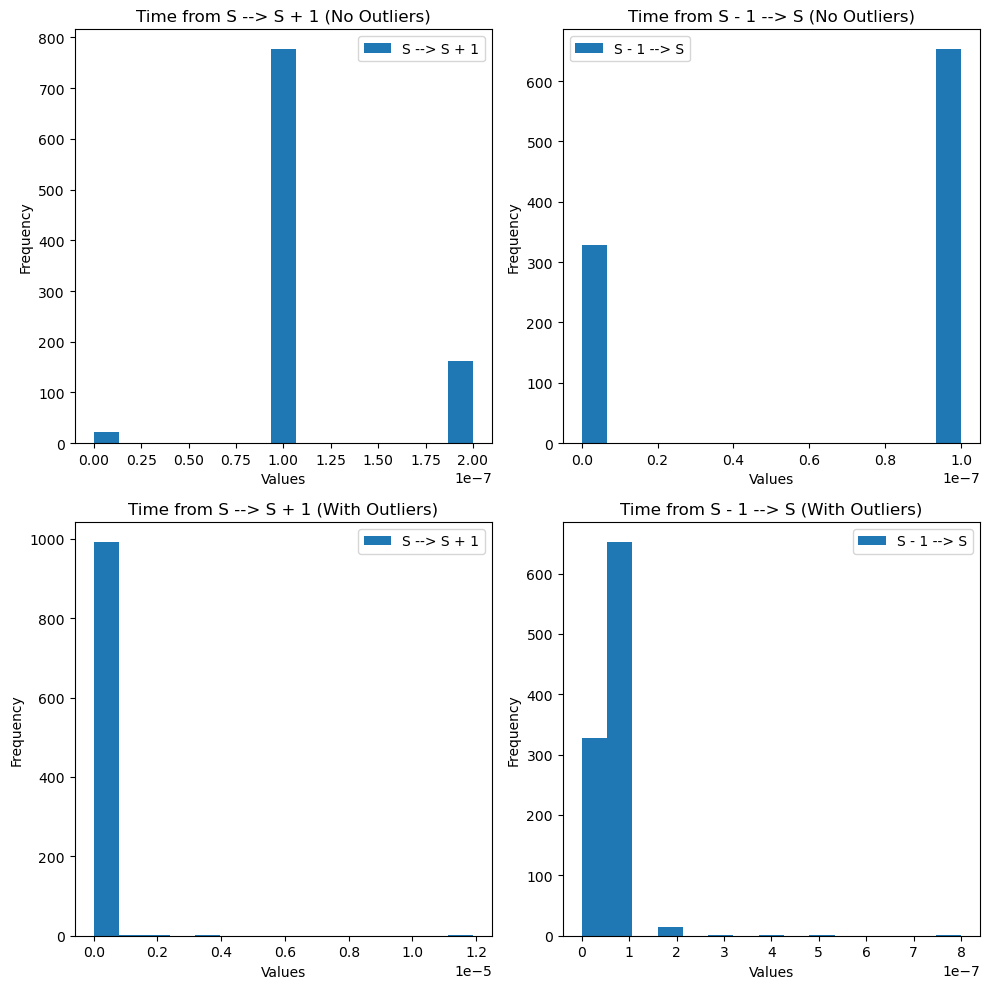

In [7]:
fig, axs = plt.subplots(nrows= 2, ncols= 2, figsize= (10, 10))

a = axs[0, 0]
b = axs[0, 1]
c = axs[1, 0]
d = axs[1, 1]

# Filter out the outliers
s_95 = np.percentile(s, 95)
s_minus_1_95 = np.percentile(s_minus_1, 95)

s_filtered = s[s <= s_95]
s_minus_1_filtered = s_minus_1[s_minus_1 <= s_minus_1_95]

# Plot the histogram
a.hist(x= s_filtered, label= 'S --> S + 1', bins= 15)
b.hist(x= s_minus_1_filtered, label= 'S - 1 --> S', bins= 15)

c.hist(x= s, label= 'S --> S + 1', bins= 15)
d.hist(x= s_minus_1, label= 'S - 1 --> S', bins= 15)

a.set_xlabel('Values')
a.set_ylabel('Frequency')
a.set_title("Time from S --> S + 1 (No Outliers)")

b.set_xlabel('Values')
b.set_ylabel('Frequency')
b.set_title("Time from S - 1 --> S (No Outliers)")

c.set_xlabel('Values')
c.set_ylabel('Frequency')
c.set_title("Time from S --> S + 1 (With Outliers)")

d.set_xlabel('Values')
d.set_ylabel('Frequency')
d.set_title("Time from S - 1 --> S (With Outliers)")

a.legend()
b.legend()
c.legend()
d.legend()

plt.tight_layout()
plt.show()

From the diagrams above, I do not notice significance in the distribution of both times (even after removing outliers). This could be because the time to compute is so small so fluctuations are inevitable